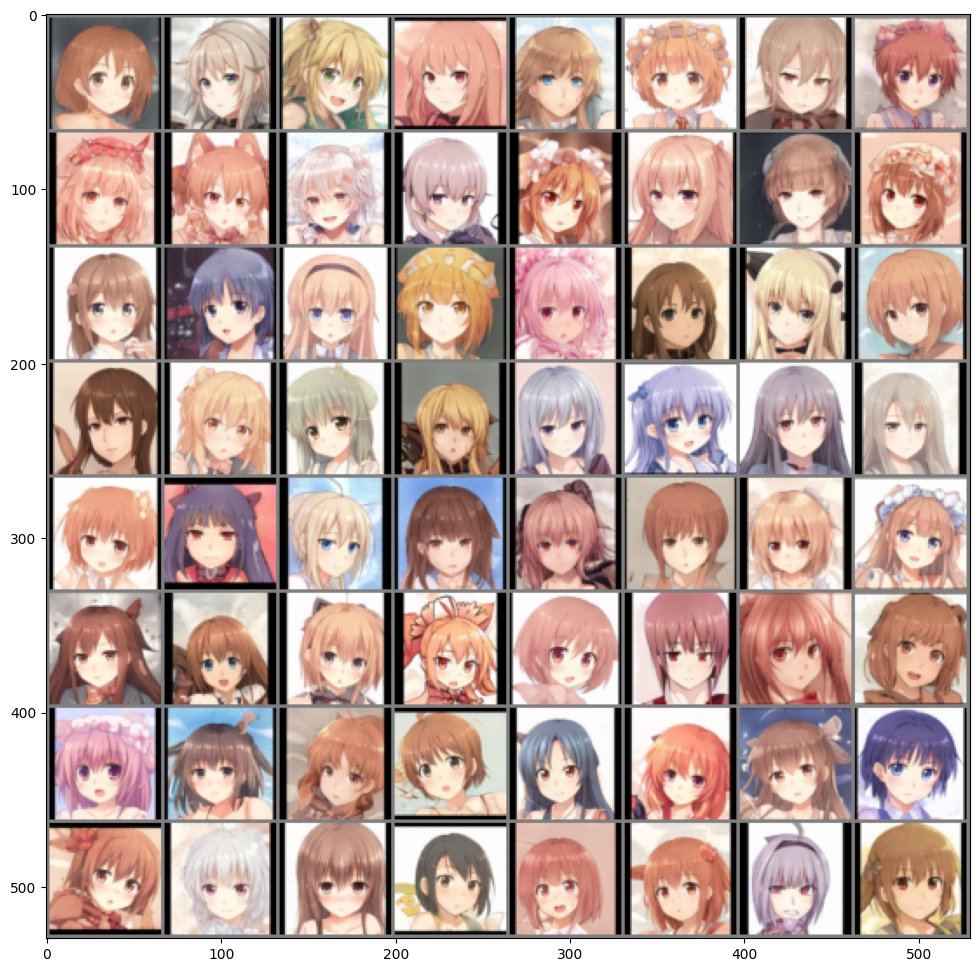

In [31]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

path = "./images"

workers = 3 # Number of workers
batch_size = 64
image_size = 128
nz = 100 # Size of z latent vector
num_epochs = 5
lr = 0.001
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers

dataset = torchvision.datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader )
images, labels = next(dataiter)
plt.figure(figsize=(12,12))
# show images
imshow(torchvision.utils.make_grid(images))



In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: 100 x 1 x 1
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")

# Create the Discriminator and Generator
netD = Discriminator().to(device)
netG = Generator().to(device)

# Apply the weight initialization function
netD.apply(initialize_weights)
netG.apply(initialize_weights)

# Loss function and optimizers
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Function to plot results
def plot_results(G_losses, D_losses):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [33]:
img_list = []
G_losses = []
D_losses = []
iters = 0

import time

# Start the timer
start_time = time.time()

# Training loop for GAN
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)

        # Preparing labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        netD.zero_grad()

        # Train with real images
        real_images = real_images.to(device)
        output_real = netD(real_images).squeeze()
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach()).squeeze()
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()

        # Update Discriminator
        optimizerD.step()
        D_loss = loss_real + loss_fake

        # -----------------
        # Train Generator
        # -----------------
        netG.zero_grad()

        # Generator tries to trick discriminator
        output_fake_for_update = netD(fake_images).squeeze()
        G_loss = criterion(output_fake_for_update, real_labels)
        G_loss.backward()

        # Update Generator
        optimizerG.step()

        # ----------------
        # Log Progress
        # ----------------
        if i % 50 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                  f'Loss D: {D_loss:.4f}, Loss G: {G_loss:.4f} '
                  f'D(x): {output_real.mean().item():.4f}, '
                  f'D(G(z)): {output_fake.mean().item():.4f} / {output_fake_for_update.mean().item():.4f}')

        # Save losses for plotting
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        # Save the generated images
        if (i + 1) % 500 == 0 or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
            with torch.no_grad():
                fixed_fake_images = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fixed_fake_images, padding=2, normalize=True))

        iters += 1

# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch [0/5] Batch [0/401] Loss D: 2.2307, Loss G: 3.6519 D(x): 0.3794, D(G(z)): 0.5811 / 0.0369
Epoch [0/5] Batch [50/401] Loss D: 0.4083, Loss G: 12.7121 D(x): 0.9946, D(G(z)): 0.1977 / 0.0000
Epoch [0/5] Batch [100/401] Loss D: 1.0123, Loss G: 18.9034 D(x): 0.5431, D(G(z)): 0.0000 / 0.0000
Epoch [0/5] Batch [150/401] Loss D: 0.2162, Loss G: 6.8639 D(x): 0.9369, D(G(z)): 0.1153 / 0.0015
Epoch [0/5] Batch [200/401] Loss D: 0.5066, Loss G: 13.7994 D(x): 0.9891, D(G(z)): 0.3700 / 0.0000
Epoch [0/5] Batch [250/401] Loss D: 0.0953, Loss G: 5.1417 D(x): 0.9507, D(G(z)): 0.0402 / 0.0066
Epoch [0/5] Batch [300/401] Loss D: 0.0529, Loss G: 6.2654 D(x): 0.9778, D(G(z)): 0.0294 / 0.0026
Epoch [0/5] Batch [350/401] Loss D: 0.0622, Loss G: 5.8412 D(x): 0.9680, D(G(z)): 0.0270 / 0.0046
Epoch [0/5] Batch [400/401] Loss D: 0.1440, Loss G: 4.8736 D(x): 0.9447, D(G(z)): 0.0717 / 0.0180
Epoch [1/5] Batch [0/401] Loss D: 0.1464, Loss G: 4.6875 D(x): 0.9462, D(G(z)): 0.0782 / 0.0196
Epoch [1/5] Batch [50/

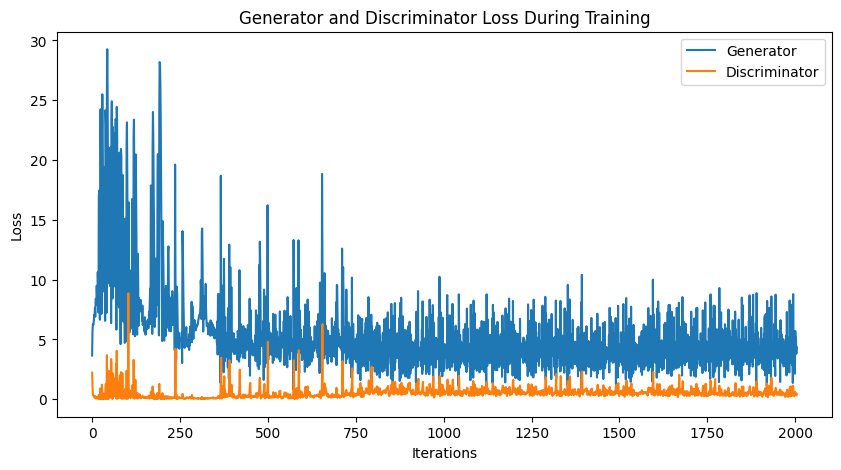

In [35]:
plot_results(G_losses,D_losses)

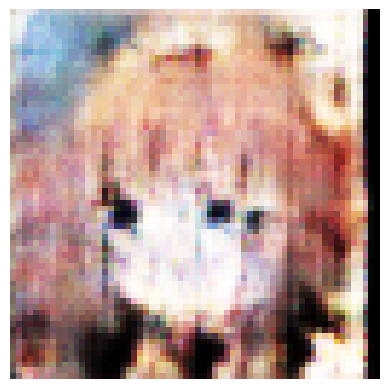

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate a fake image
noise = torch.randn(1, nz, 1, 1, device=device)
fake_image = netG(noise)

# Process the fake image for display
fake_image = (fake_image.to("cpu").clone().detach().squeeze(0).numpy().transpose(1, 2, 0) + 1) / 2
fake_image = np.clip(fake_image, 0, 1)

# Display the image
plt.imshow(fake_image)
plt.axis('off')
plt.show()


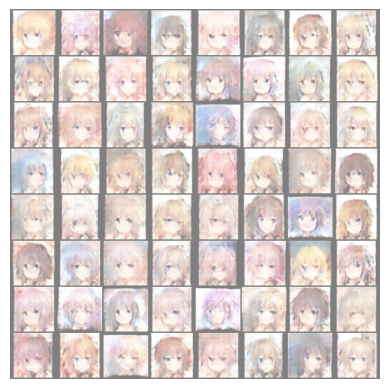

In [37]:
fake_image = img_list[0]

# Process the fake image for display
fake_image = (fake_image.to("cpu").clone().detach().squeeze(0).numpy().transpose(1, 2, 0) + 1) / 2
fake_image = np.clip(fake_image, 0, 1)

# Display the image
plt.imshow(fake_image)
plt.axis('off')
plt.show()